In [10]:
from train.training_session_v2 import load_training_session
import multiprocessing
import torch

device = "cuda"

session = load_training_session(
    save_path="saves/phase3/objectives/baseline_gwilliams_latent_loss_no_latent_alignment/epoch_38",
    studies={"gwilliams2023": "audiotext"},
    data_path="data",
    cache_name="/home/ubuntu/cache",
)

dataloader = session.get_dataloader(buffer_size=1, num_workers=1, max_cache_size=100, tokenize=True, add_timestamps=True)

# Unseen both
# recording = session.studies["gwilliams2023"].recordings[19][0][0]

# Seen
# recording = session.studies["gwilliams2023"].recordings[15][0][1]

# Unseen task
recording = session.studies["gwilliams2023"].recordings[18][0][0]

# Unseen subject
# recording = session.studies["gwilliams2023"].recordings[19][0][1]

print(
    f"Showing recording: {recording.study_name}_{recording.subject_id}_{recording.task_id}"
)

dataloader.start_fetching(recordings=[recording])
batch = dataloader.get_recording()
(
    brain, 
    audio, 
    transcripts,
    transcript_attn_masks,
    recording,
) = (
    batch.brain_segments["all"].to(device),
    batch.audio_segments.to(device),
    batch.transcript.to(device),
    batch.transcript_attention_masks.to(device),
    batch.recording,
)


conditions = {
    "study": f"{recording.study_name}",
    "subject": f"{recording.study_name}_{recording.subject_id}",
}
session.model.to(device).eval()

# with torch.no_grad():
#     (
#         x,  # [B, C, T]
#         quantizer_metrics,
#         channel_weights,
#         hidden_outputs,
#         encoder_hidden_states,  # L * [B, T, D]
#     ) = session.model(
#         x=[brain],
#         recording=[recording],
#         conditions=[conditions],
#         mel=[audio],
#         train=False,
#         return_hidden_outputs=False,
#     )

pad_len = 3000 - audio.size(2)
encoder_attention_mask = torch.zeros(
    audio.size(0), 3000, device=device
)  # [B, T]
encoder_attention_mask[:, : audio.size(2)] = 1

(
    token_ids,  # [B, T]
    x,  # [B, 80, T']
    quantizer_metrics,
    channel_weights,
    hidden_outputs,
) = session.model.generate(
    x=brain,
    recording=recording,
    conditions=conditions,
    mel=None,
    max_new_tokens=int(16 * session.config.window_size),
    attention_mask=encoder_attention_mask,
    return_hidden_outputs=False,
)

dataloader.stop()

Loading Gwilliams2023 with batch type audiotext
Data partitioned on studies ['gwilliams2023'].
Train: 135, Unseen Task: 45, Unseen Subject: 12, Unseen Both: 4.

RNNEncoder initialized as conformer with 4 layers, 256 d_model, 4 nhead
	Embedding: sinusoidal, params: 6075392
SimpleConv initialized with 8927984 parameters, cond: ['study', 'subject']
Merger False, merger channels 0
ConvBlocks: 4, hidden_dim: 256, params 2626048
Found 40 target modules for AdaLora: ['model.decoder.layers.0.self_attn.k_proj', 'model.decoder.layers.0.self_attn.v_proj', 'model.decoder.layers.0.self_attn.q_proj', 'model.decoder.layers.0.self_attn.out_proj', 'model.decoder.layers.0.encoder_attn.k_proj', 'model.decoder.layers.0.encoder_attn.v_proj', 'model.decoder.layers.0.encoder_attn.q_proj', 'model.decoder.layers.0.encoder_attn.out_proj', 'model.decoder.layers.0.fc1', 'model.decoder.layers.0.fc2', 'model.decoder.layers.1.self_attn.k_proj', 'model.decoder.layers.1.self_attn.v_proj', 'model.decoder.layers.1.self_

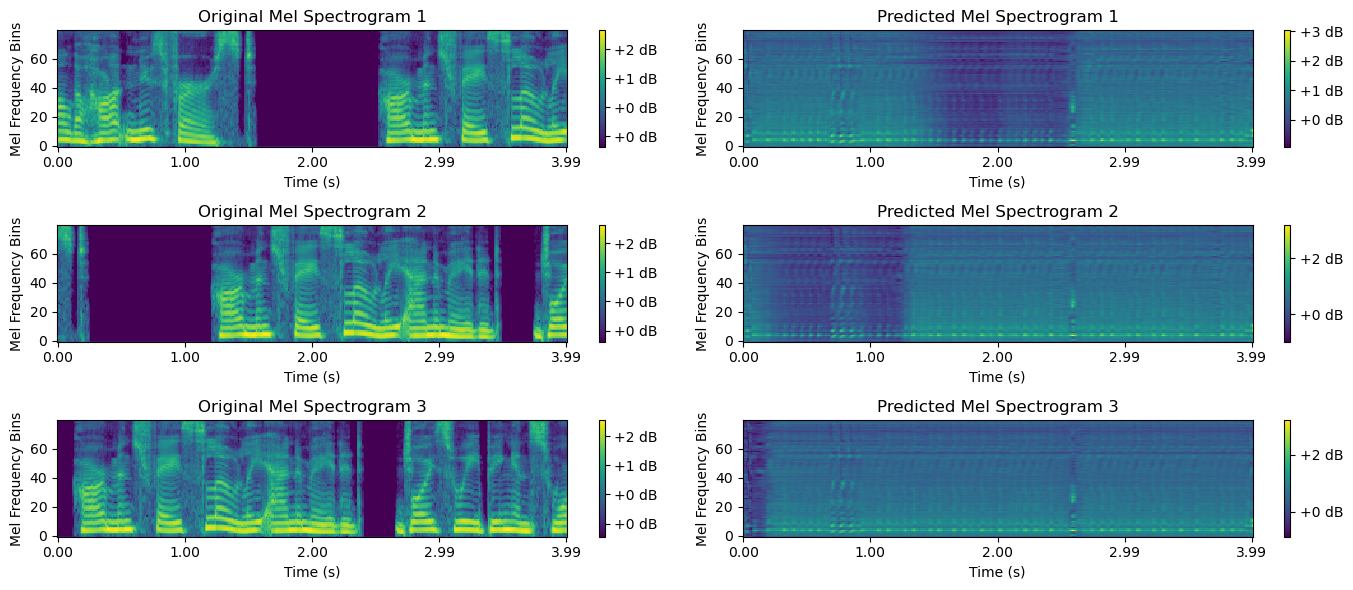

In [11]:
from utils.plot_mel import plot_mel_spectrogram

plot_mel_spectrogram(
    x=audio[15:18].cpu().numpy(),
    max_plots=3,
    x_pred=x[15:18].cpu().numpy(),
)

In [50]:
audio[17][:, 380:]

tensor([[-0.2237, -0.2237, -0.2237,  ..., -0.2237, -0.2237, -0.2237],
        [-0.2237, -0.2237, -0.2237,  ..., -0.2237, -0.2237, -0.2237],
        [-0.2237, -0.2237, -0.2237,  ..., -0.2237, -0.2237, -0.2237],
        ...,
        [-0.2237, -0.2237, -0.2237,  ..., -0.2237, -0.2237, -0.2237],
        [-0.2237, -0.2237, -0.2237,  ..., -0.2237, -0.2237, -0.2237],
        [-0.2237, -0.2237, -0.2237,  ..., -0.2237, -0.2237, -0.2237]],
       device='cuda:0')

In [12]:
audio.max(), audio.min(), audio.mean(), audio.std(), x.max(), x.min(), x.mean(), x.std()

(tensor(1.8745, device='cuda:0'),
 tensor(-0.2498, device='cuda:0'),
 tensor(0.4936, device='cuda:0'),
 tensor(0.4758, device='cuda:0'),
 tensor(3.2289, device='cuda:0'),
 tensor(-1.2825, device='cuda:0'),
 tensor(0.5308, device='cuda:0'),
 tensor(0.3221, device='cuda:0'))

In [21]:
decoded_output = session.tokenizer.batch_decode(
    sequences=token_ids[15:25],
    skip_special_tokens=True,
    decode_with_timestamps=False,
    clean_up_tokenization_spaces=True,
)
# Remove extra spaces
decoded_output = [
    " ".join([w for w in sentence.split(" ") if w]) for sentence in decoded_output
]
decoded_output

['the way to the door that was just a moment where I said I need to be a a',
 '',
 'I',
 'the world seemed be away standing over him with his hand as',
 'the way to the door to the window the window was too much in time',
 'the way to the door out of his window there was no sight there from',
 'He thought about getting the green green shade inside of the green tree',
 'of the giant hood and a little hot hand hand',
 'the way to the door out of his window there was no sight there was',
 'He thought about giving me a ily shot of a bear with his']

In [ ]:
decoded_label = session.tokenizer.batch_decode(
    sequences=transcripts[15:25],
    skip_special_tokens=True,
    decode_with_timestamps=False,
    clean_up_tokenization_spaces=True,
)
decoded_label = [
    " ".join([w for w in sentence.split(" ") if w]) for sentence in decoded_label
]
decoded_label

['the hot news first face',
 'face slowly animated',
 'face slowly animated joy sweeping in',
 'animated joy sweeping in to replace stern',
 'in to replace stern concentration',
 'concentration says the',
 'says the',
 'the',
 'planet tiny',
 'planet tiny away']

: 